In [74]:
# fench the data

from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

tarball_path=Path("datasets/housing.tgz")
def load_housing_data():

 if not tarball_path.is_file():
    Path("datasets").mkdir(parents=True,exist_ok=True)

    url = "https://github.com/ageron/data/raw/main/housing.tgz"

    urllib.request.urlretrieve(url,tarball_path)

    with tarfile.open(tarball_path) as housing_tarball:
        housing_tarball.extractall(path="datasets")

 return pd.read_csv(Path("datasets/housing/housing.csv"))
housing=load_housing_data()

housing.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [75]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


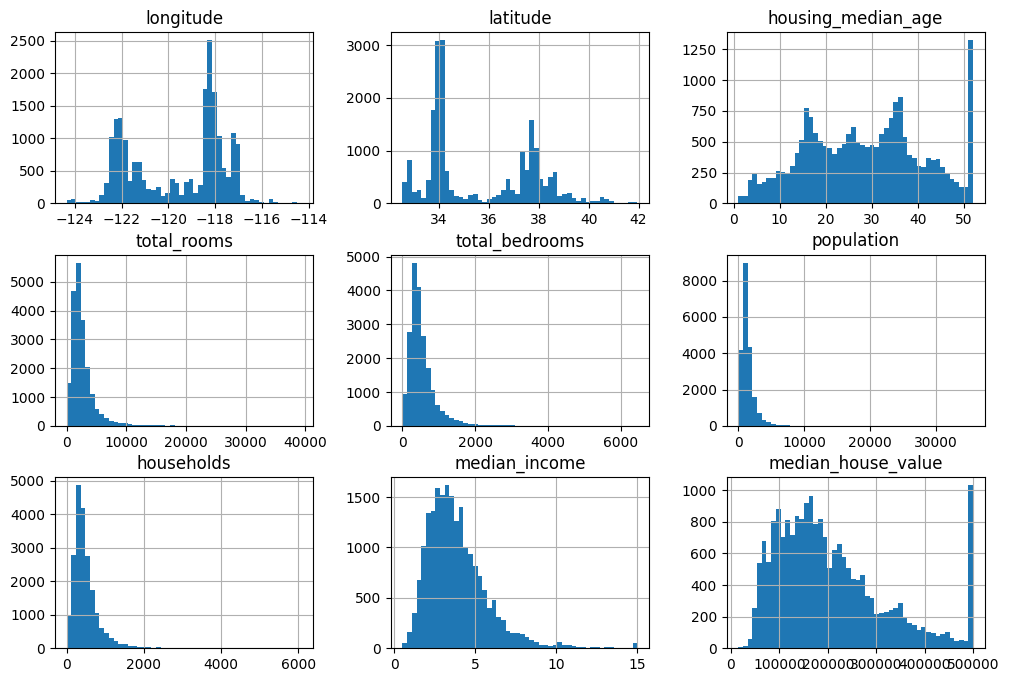

In [76]:
import matplotlib.pyplot as plt

housing.hist(bins=50,figsize=(12,8))

plt.show()

In [77]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

| Category | Income Range (in \$1000s) |
| -------- | ------------------------- |
| 1        | 0 to 15k                  |
| 2        | 15k to 30k                |
| 3        | 30k to 45k                |
| 4        | 45k to 60k                |
| 5        | more than 60k             |


In [78]:
# shuffle and split the data
import numpy as np
housing["income_cat"]=pd.cut(housing["median_income"],bins=[0.,1.5,3.,4.5,6.,np.inf],labels=[1,2,3,4,5])


In [79]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter=StratifiedShuffleSplit(n_splits=10,test_size=0.2,random_state=42)

strat_split=[]

for train_index , test_index in splitter.split(housing,housing["income_cat"]):
    strat_train_set_n=housing.iloc[train_index]
    strat_test_set_n=housing.iloc[test_index]
    strat_split.append([strat_train_set_n,strat_test_set_n])

strat_train_set, strat_test_set =strat_split[0]

strat_test_set["income_cat"].value_counts()/len(strat_test_set)


income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [80]:
for set_ in (strat_train_set, strat_test_set):
 set_.drop("income_cat", axis=1, inplace=True)

C:\Users\nitya\AppData\Local\Temp\ipykernel_19892\438350011.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop("income_cat", axis=1, inplace=True)
C:\Users\nitya\AppData\Local\Temp\ipykernel_19892\438350011.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop("income_cat", axis=1, inplace=True)


In [81]:
housing=strat_train_set.copy()

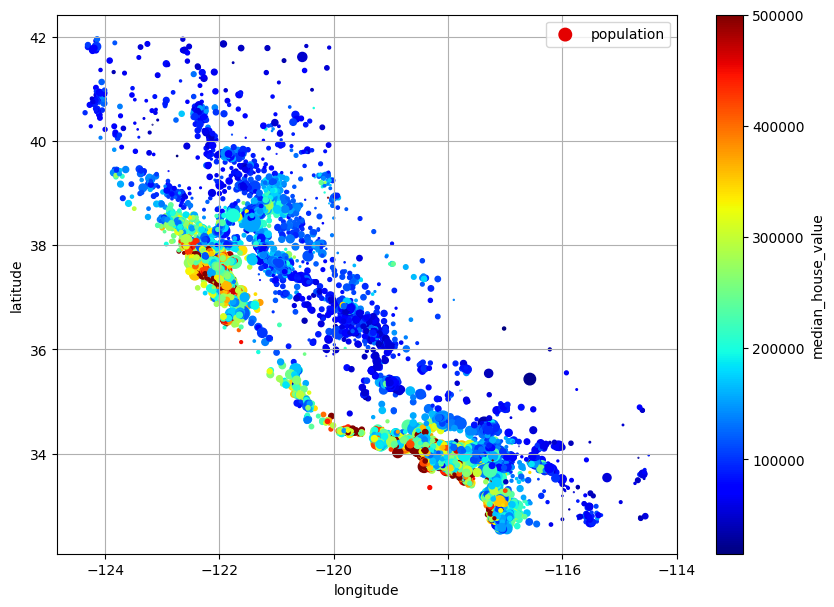

In [82]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
 s=housing["population"] / 100, label="population",
 c="median_house_value", cmap="jet", colorbar=True,
 legend=True, sharex=False, figsize=(10, 7))
plt.show()

In [83]:
corr_matrix=housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

In [84]:
housing=strat_train_set.drop("median_house_value",axis=1)
housing_label=strat_train_set["median_house_value"].copy()

In [93]:
#adding as per use
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression


In [94]:
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]



In [95]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]],
                                           sample_weight=housing_label)

In [96]:
similarities[:3].round(2)

array([[0.  , 0.98, 0.  , 0.  , 0.  , 0.  , 0.13, 0.55, 0.  , 0.56],
       [0.64, 0.  , 0.11, 0.04, 0.  , 0.  , 0.  , 0.  , 0.99, 0.  ],
       [0.  , 0.65, 0.  , 0.  , 0.01, 0.  , 0.49, 0.59, 0.  , 0.28]])

In [103]:
#making a coustom transformer pipeline

def column_ratio(x):
    return x[: ,[0]]/ x[: ,[1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]

def ratio_pipeline():
    return make_pipeline(SimpleImputer(strategy="median"),FunctionTransformer(column_ratio,feature_names_out=ratio_name),StandardScaler())

log_pipeline=make_pipeline(SimpleImputer(strategy="median"),FunctionTransformer(np.log,feature_names_out="one-to-one"),StandardScaler())

cluster_simil=ClusterSimilarity(n_clusters=10,gamma=1,random_state=42)

default_num_pipeline=make_pipeline(SimpleImputer(strategy="median"),StandardScaler())

cat_pipeline=make_pipeline(SimpleImputer(strategy="most_frequent"),OneHotEncoder(handle_unknown="ignore"))

preprocessing=ColumnTransformer([
    ("bedrooms",ratio_pipeline(),["total_bedrooms","total_rooms"]),
    ("rooms_per_house",ratio_pipeline(),["total_rooms","households"]),
    ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", "drop", ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),

] ,remainder="passthrough")

In [104]:
housing_prepared = preprocessing.fit_transform(housing)

In [105]:
housing_prepared.shape

(16512, 14)

In [106]:
feature_names = []

# 1. Bedrooms ratio
feature_names += ["bedrooms_ratio"] 

# 2. Rooms per house
feature_names += ["rooms_per_house_ratio"]

# 3. People per house
feature_names += ["people_per_house_ratio"]

# 4. Log pipeline (5 features, unchanged names)
feature_names += ["log_total_bedrooms", "log_total_rooms", "log_population", "log_households", "log_median_income"]

# 5. Cluster similarity
feature_names += ["location_cluster"]

# 6. Categorical columns (from OneHotEncoder)
cat_encoder = preprocessing.named_transformers_['cat'].named_steps["onehotencoder"]
cat_columns = cat_encoder.get_feature_names_out(preprocessing.transformers_[5][2]).tolist()
feature_names += cat_columns

print("All final feature names:")
print(feature_names)
print("Total:", len(feature_names))


All final feature names:
['bedrooms_ratio', 'rooms_per_house_ratio', 'people_per_house_ratio', 'log_total_bedrooms', 'log_total_rooms', 'log_population', 'log_households', 'log_median_income', 'location_cluster', 'ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND', 'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN']
Total: 14


In [107]:
lig_reg=make_pipeline(preprocessing,LinearRegression())
lig_reg.fit(housing,housing_label)

,steps,"[('columntransformer', ...), ('linearregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('bedrooms', ...), ('rooms_per_house', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
#checking accuracy
housing_prediction=lig_reg.predict(housing)
housing_prediction[:5].round(-2)
from sklearn.metrics import root_mean_squared_error

line_rmse = root_mean_squared_error(housing_label, housing_prediction)
print("Root Mean Squared Error (RMSE):", line_rmse)
#it is not that much good but for understanding it is okay

Root Mean Squared Error (RMSE): 72017.3965849894


In [ ]:
new_data = pd.DataFrame([{
    "longitude": -122.23,
    "latitude": 37.88,
    "housing_median_age": 41.0,
    "total_rooms": 880.0,
    "total_bedrooms": 129.0,
    "population": 322.0,
    "households": 126.0,
    "median_income": 8.3252,
    "ocean_proximity": "NEAR BAY"
}])

# Predict
predicted_price = lig_reg.predict(new_data)
print("Predicted house price:", round(predicted_price[0], 2))#just testing

Predicted house price: 376900.58


In [ ]:
longitude = float(input("Enter longitude: "))
latitude = float(input("Enter latitude: "))
housing_median_age = float(input("Enter housing median age: "))
total_rooms = float(input("Enter total rooms: "))
total_bedrooms = float(input("Enter total bedrooms: "))
population = float(input("Enter population: "))
households = float(input("Enter number of households: "))
median_income = float(input("Enter median income: "))
ocean_proximity = input("Enter ocean proximity (e.g., <1H OCEAN / INLAND / NEAR BAY): ")

#  Create dataframe for model prediction
new_data = pd.DataFrame([{
    "longitude": longitude,
    "latitude": latitude,
    "housing_median_age": housing_median_age,
    "total_rooms": total_rooms,
    "total_bedrooms": total_bedrooms,
    "population": population,
    "households": households,
    "median_income": median_income,
    "ocean_proximity": ocean_proximity
}])

#  Predict
predicted_price = lig_reg.predict(new_data)
print("Predicted house price:", round(predicted_price[0], 2))